In [1]:
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-kuhij72b
  Running command git clone --filter=blob:none --quiet https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-kuhij72b
  Resolved https://github.com/haven-jeon/PyKoSpacing.git to commit b32a889cbd10b006d2f4aba118f0cd5b677e2979
  Preparing metadata (setup.py) ... done
  Created wheel for pykospacing: filename=pykospacing-0.5-py3-none-any.whl size=2286920 sha256=017bdbc7de7a79b56031614875213af8e8c19a00b83391065cac675c3dcd70d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-8agsp8z1/wheels/76/b3/33/dda14886ee76b8e53eb05580a14dfcf9145e9eb9d282c53f28
Successfully built pykospacing


In [1]:
!pip install pykospacing

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [1]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 20.0 MB/s eta 0:00:00


In [1]:
import pickle
import pandas as pd
from konlpy.tag import Okt
from pykospacing import Spacing
from tqdm.auto import tqdm


# 동의어 교체 함수
def sr_augment(data_path, save_path, wordnet_path):

    # 교체 문장 생성 함수
    def s_maker(sentence, common, synonym):

        # 조사 교정 함수
        def change_josa(noun, josa):

            # 한글의 유니코드가 28로 나누어 떨어지면 받침이 없음
            if josa == "이" or josa == "가":
                return "이" if (ord(noun[-1]) - ord("가")) % 28 == 0 else "가" # 책이 / 사과가
            elif josa == "을" or josa == "를":
                return "을" if (ord(noun[-1]) - ord("가")) % 28 == 0 else "를" # 책을 / 사과를
            elif josa == "과" or josa == "와":
                return "과" if (ord(noun[-1]) - ord("가")) % 28 == 0 else "와" # 책과 / 사과와
            else:
                return josa

        spacing = Spacing()

        replace_sentence = []

        # 조사 체크
        check = set(['이', '가', '을', '를', '과', '와'])

        for i in range(len(sentence)):
            # 문장에서 동의어 추가
            if sentence[i][0] == common:
                replace_sentence.append(synonym)

                # 뒷말이 조사면 조사 교정
                if i + 1 < len(sentence) and sentence[i+1][1] == 'Josa' and sentence[i+1][0] in check:
                    sentence[i + 1] = (
                    change_josa(replace_sentence[-1][0], sentence[i + 1][0]),
                    'Josa',
                )
            else:
                replace_sentence.append(sentence[i][0])

        # 형태소 연결 및 문장 생성
        replace_sentence = "".join(replace_sentence)
        replace_sentence = spacing(replace_sentence)

        return replace_sentence

    # 동의어 사전 불러오기
    with open(wordnet_path, "rb") as f:
        wordnet = pickle.load(f)

    # 데이터 불러오기
    data = pd.read_csv(data_path)
    s1, s2 = data['sentence_1'], data['sentence_2']

    okt = Okt() # Okt -> 한국어 텍스트에서 명사, 동사, 형용사 등을 추출

    sr_sentence = []

    for i in tqdm(range(len(s1)), desc='sr_sentence'):

        # i번째 문장에서 명사만 추출
        n1 = okt.nouns(s1[i])
        n2 = okt.nouns(s2[i])

        # s1과 s2의 공통된 명사를 추출
        common = set(n1) & set(n2)

        for com in common:

            # 길이가 2 이상 (분석기 오류 예방), wordnet에 있는지 확인
            if len(com) >=2 and com in wordnet and len(wordnet[com]) >= 2:
                # 동의어 추출
                synonym = wordnet[com][1:]

                for syn in synonym:
                    # 형태소 단위로 분리 및 품사 태그와 함께 추출
                    s1_tag = okt.pos(s1[i])
                    s2_tag = okt.pos(s2[i])

                    # 동의어 변환 및 추가
                    sr_sentence.append([
                        data['id'][i],
                        data['source'][i],
                        s_maker(s1_tag, com, syn),
                        s_maker(s2_tag, com, syn),
                        data['label'][i],
                        data['binary-label'][i],
                    ])

    # list -> df
    sr_sentence = pd.DataFrame(
        sr_sentence,
        columns=['id', 'source', 'sentence_1', 'sentence_2', 'label', 'binary-label']
    )

    # label 값이 1보다 크거나 같은 것만 추가해서 저장
    sr_sentence = sr_sentence[sr_sentence['label'] >= 1]

    result = pd.concat([data, sr_sentence])
    result.to_csv(save_path, index=False)


sr_augment("train_all.csv", "SR_train_5.csv", "wordnet.pickle") # wordnet.pickle -> KAIST에서 만든 Korean WordNet(KWN)


FileNotFoundError: [Errno 2] No such file or directory: 'wordnet.pickle'

In [3]:
import pickle
import pandas as pd
from konlpy.tag import Okt
from pykospacing import Spacing
from tqdm.auto import tqdm


# 동의어 교체 함수
def sr_augment(data_path, save_path, wordnet_path):

    # 교체 문장 생성 함수
    def s_maker(sentence, common, synonym):

        # 조사 교정 함수
        def change_josa(noun, josa):

            # 한글의 유니코드가 28로 나누어 떨어지면 받침이 없음
            if josa == "이" or josa == "가":
                return "이" if (ord(noun[-1]) - ord("가")) % 28 == 0 else "가" # 책이 / 사과가
            elif josa == "을" or josa == "를":
                return "을" if (ord(noun[-1]) - ord("가")) % 28 == 0 else "를" # 책을 / 사과를
            elif josa == "과" or josa == "와":
                return "과" if (ord(noun[-1]) - ord("가")) % 28 == 0 else "와" # 책과 / 사과와
            else:
                return josa

        spacing = Spacing()

        replace_sentence = []

        # 조사 체크
        check = set(['이', '가', '을', '를', '과', '와'])

        for i in range(len(sentence)):
            # 문장에서 동의어 추가
            if sentence[i][0] == common:
                replace_sentence.append(synonym)

                # 뒷말이 조사면 조사 교정
                if i + 1 < len(sentence) and sentence[i+1][1] == 'Josa' and sentence[i+1][0] in check:
                    sentence[i + 1] = (
                    change_josa(replace_sentence[-1][0], sentence[i + 1][0]),
                    'Josa',
                )
            else:
                replace_sentence.append(sentence[i][0])

        # 형태소 연결 및 문장 생성
        replace_sentence = "".join(replace_sentence)
        replace_sentence = spacing(replace_sentence)

        return replace_sentence

    # 동의어 사전 불러오기
    with open(wordnet_path, "rb") as f:
        wordnet = pickle.load(f)

    # 데이터 불러오기
    data = pd.read_csv(data_path)
    s1, s2 = data['sentence_1'], data['sentence_2']

    okt = Okt() # Okt -> 한국어 텍스트에서 명사, 동사, 형용사 등을 추출

    sr_sentence = []

    for i in tqdm(range(len(s1)), desc='sr_sentence'):

        # i번째 문장에서 명사만 추출
        n1 = okt.nouns(s1[i])
        n2 = okt.nouns(s2[i])

        # s1과 s2의 공통된 명사를 추출
        common = set(n1) & set(n2)

        for com in common:

            # 길이가 2 이상 (분석기 오류 예방), wordnet에 있는지 확인
            if len(com) >=2 and com in wordnet and len(wordnet[com]) >= 2:
                # 첫번째 동의어 추출
                synonym = wordnet[com][1]

                # 형태소 단위로 분리 및 품사 태그와 함께 추출
                s1_tag = okt.pos(s1[i])
                s2_tag = okt.pos(s2[i])

                # 동의어 변환 및 추가
                sr_sentence.append([
                    data['id'][i],
                    data['source'][i],
                    s_maker(s1_tag, com, synonym),
                    s_maker(s2_tag, com, synonym),
                    data['label'][i],
                    data['binary-label'][i],
                ])

    # list -> df
    sr_sentence = pd.DataFrame(
        sr_sentence,
        columns=['id', 'source', 'sentence_1', 'sentence_2', 'label', 'binary-label']
    )

    # label 값이 1보다 크거나 같은 것만 추가해서 저장
    sr_sentence = sr_sentence[sr_sentence['label'] >= 1]

    result = pd.concat([data, sr_sentence])
    result.to_csv(save_path, index=False)


sr_augment("train_all.csv", "SR_train_6.csv", "wordnet.pickle") # wordnet.pickle -> KAIST에서 만든 Korean WordNet(KWN)


sr_sentence:   0%|          | 0/9324 [00:00<?, ?it/s]

In [4]:
import pandas as pd

sr_df = pd.read_csv('SR_train_6.csv')

total_count = len(sr_df)
label_zero_count = (sr_df['label'] == 0).sum()
label_zero_ratio = label_zero_count / total_count

print(f"전체 데이터 개수: {total_count}")
print(f"Label이 0인 데이터 개수: {label_zero_count}")
print(f"Label이 0인 데이터 비율: {label_zero_ratio:.2%}")

전체 데이터 개수: 10904
Label이 0인 데이터 개수: 2119
Label이 0인 데이터 비율: 19.43%


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPyt

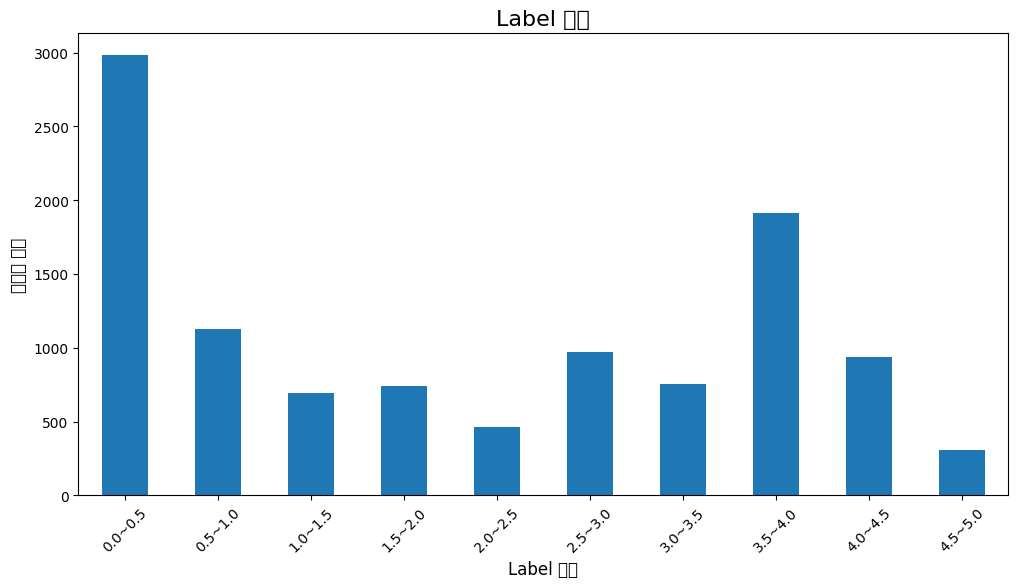

In [5]:
import matplotlib.pyplot as plt
import numpy as np

min_label = sr_df['label'].min()
max_label = sr_df['label'].max()

bins = np.arange(min_label, max_label + 0.5, 0.5)

labels = [f'{round(bins[i], 1)}~{round(bins[i+1], 1)}' for i in range(len(bins)-1)]

sr_df['label_range'] = pd.cut(sr_df['label'], bins=bins, labels=labels, include_lowest=True)

label_range_counts = sr_df['label_range'].value_counts().sort_index()

# 막대 그래프 시각화
plt.figure(figsize=(12, 6))
label_range_counts.plot(kind='bar')
plt.title('Label 분포', fontsize=16)
plt.xlabel('Label 범위', fontsize=12)
plt.ylabel('데이터 개수', fontsize=12)
plt.xticks(rotation=45)
plt.show()